In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torchvision.datasets as dtst
from torch import optim

from PIL import Image

import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# import warnings
# warnings.filterwarnings('ignore')

%matplotlib inline

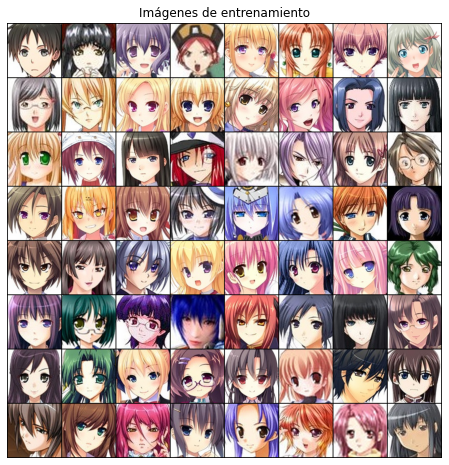

In [3]:
torch.manual_seed(42)

# Asignamos  los paths de las imagenes en variables

data_folder = './images'

# Definimos las características de las imágenes

image_size = 128  #nustras imágenes tienen por dimensión 128*128

batch_size = 64  #será el conjunto de imagenes que se agarra por lote,
# como estamos trabajando con casi 40 mil imágenes, tomaremos de 128 en 128
# si el proceso no muestra buen rendimiento, se trabajará con
# un valor distinto

# Cantidad de hilos
workers = 4

# como nuestras imágenes son a color. Se trabajan 3 canales (RGB)
channels = 3

dimension_z = 200
ngf = 32
ndf = 32

num_epochs = 100

# Según una publicación del creador del optimizador Adam, el mejor ratio
# de aprendizaje es 3e-4
lr = 3e-4

# Esto hace referencia a que se usa la GPU:1 del computador,
# suele ser la principal y es válido cuando se tiene una tarjeta  de video
# compatible con CUDA
ngpu = 1

# Usaremos una función genérica para convertir las imágenes en tensores
dsimgs = dtst.ImageFolder(
    root=data_folder,
    transform=transforms.Compose([
        # Se usa el resize en caso no todas las imágenes de entrada tengan el tamaño de 128px
        transforms.Resize(image_size),
        # CenterCrop busca recortar la imagen en caso sea muy grande al tamaño dado
        transforms.CenterCrop(image_size),
        # ToTensor convierte finalmente la imagen a tensor
        transforms.ToTensor(),
        # Normalize permite la normalización de la información
        # El problema encontrado es que necesitamos hallar la desviación estandar
        # media de toda la información para realizar una correcta normalización
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]))

# DataLoader es básicamente un iterador que nos ayudará para el recorrido
# a través de las imágenes o información en general.
dt_loader = DataLoader(dsimgs,
                       batch_size=batch_size,
                       shuffle=True,
                       num_workers=workers)

# Aquí debería dejarse como el comentario
device = torch.device("cuda:0" if (
    torch.cuda.is_available() and ngpu > 0) else "cpu")

batch_imagenes = next(iter(dt_loader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Imágenes de entrenamiento")
plt.imshow(
    np.transpose(
        make_grid(batch_imagenes[0].to(device)[:64], padding=2,
                  normalize=True).cpu(), (1, 2, 0)))

In [4]:
def noise_generator(n, dimension, device):
    return torch.randn(n, dimension, device=device)

In [5]:
class redGeneradora(nn.Module):
    def __init__(
        self,
        dimension_z=10,  # por   defecto un valor pequeño
        dimension_hidd=32,  #  valor múltiplo de la dimensión oculta
        img_chan=3,  # 3 canales para el color (RGB)
        kernel_size=2,  # Kernel de 2*2 
        stride=2  # Stride de 2 pasos
    ):
        super(redGeneradora, self).__init__()
        self.dimension_z = dimension_z
        self.main = nn.Sequential(
            # Añadir proceso
            ### CT01 - inpt=200 -> 32*32=1024
            nn.ConvTranspose2d(dimension_z,
                               dimension_hidd * 32,
                               kernel_size=2,
                               stride=1,
                               padding=0),
            nn.BatchNorm2d(dimension_hidd * 32),
            nn.LeakyReLU(0.01, inplace=True),
            ### CT02 - inpt=1024 -> 16*32=512
            nn.ConvTranspose2d(dimension_hidd * 32,
                               dimension_hidd * 16,
                               kernel_size=4,
                               stride=2,
                               padding=1),
            nn.BatchNorm2d(dimension_hidd * 16),
            nn.LeakyReLU(0.01, inplace=True),
            ### CT03 - inpt=512 -> 8*32=256
            nn.ConvTranspose2d(dimension_hidd * 16,
                               dimension_hidd * 8,
                               kernel_size=3,
                               stride=1,
                               padding=1),
            nn.BatchNorm2d(dimension_hidd * 8),
            nn.LeakyReLU(0.01, inplace=True),
            ### CT04 - inpt=256 -> 4*32=128
            nn.ConvTranspose2d(dimension_hidd * 8,
                               dimension_hidd * 4,
                               kernel_size=2,
                               stride=2,
                               padding=0),
            nn.BatchNorm2d(dimension_hidd * 4),
            nn.LeakyReLU(0.01, inplace=True),
            ### CT05 - inpt=128 -> 4*32=128
            nn.ConvTranspose2d(dimension_hidd * 4,
                               dimension_hidd * 4,
                               kernel_size=2,
                               stride=2,
                               padding=0),
            nn.BatchNorm2d(dimension_hidd * 4),
            nn.LeakyReLU(0.01, inplace=True),
            ### CT06 - inpt=128 -> 2*32=64
            nn.ConvTranspose2d(dimension_hidd * 4,
                               dimension_hidd * 2,
                               kernel_size=4,
                               stride=2,
                               padding=1),
            nn.BatchNorm2d(dimension_hidd * 2),
            nn.LeakyReLU(0.01, inplace=True),
            ### CT07 - inpt=64 -> 32
            nn.ConvTranspose2d(dimension_hidd * 2,
                               dimension_hidd,
                               kernel_size=2,
                               stride=2,
                               padding=0),
            nn.BatchNorm2d(dimension_hidd),
            nn.LeakyReLU(0.01, inplace=True),
            ### CT08 - inpt=32 -> 3
            nn.ConvTranspose2d(dimension_hidd,
                               img_chan,
                               kernel_size=2,
                               stride=2,
                               padding=0),
            nn.Tanh())

    # Con forward vamos a devolver las imágenes generadas
    def forward(self, input_arr):
        x = noise.view(len(input_arr), self.dimension_z, 1, 1)
        return self.main(x)

In [9]:
class redDiscriminadora(nn.Module):
    def __init__(self,
                 dimension_z=10,
                 dimension_hidd=64,
                 img_chan=3,
                 kernel_size=2,
                 stride=2):
        super(redDiscriminadora, self).__init__()
        self.main = nn.Sequential(
            # Conv01 128*128 = 32*32   -> 64
            nn.Conv2d(img_chan,
                      dimension_hidd,
                      kernel_size=4,
                      stride=2,
                      padding=1),
            nn.BatchNorm2d(dimension_hidd),
            nn.LeakyReLU(0.2, inplace=True),
            # Conv02 -> 32
            nn.Conv2d(dimension_hidd,
                      dimension_hidd * 2,
                      kernel_size=8,
                      stride=2,
                      padding=3),
            nn.BatchNorm2d(dimension_hidd * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Conv03 -> 16
            nn.Conv2d(dimension_hidd * 2,
                      dimension_hidd * 4,
                      kernel_size=4,
                      stride=2,
                      padding=1),
            nn.BatchNorm2d(dimension_hidd * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Conv04 -> 4
            nn.Conv2d(dimension_hidd * 4,
                      dimension_hidd * 8,
                      kernel_size=8,
                      stride=4,
                      padding=2),
            nn.BatchNorm2d(dimension_hidd * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Conv05 -> 1
            nn.Conv2d(dimension_hidd * 8,
                      1,
                      kernel_size=4,
                      stride=2,
                      padding=0))

    def forward(self, input_arr):
        y = self.main(input_arr)
        return y.view(len(y), -1)

In [10]:

# Función de pérdida del tipo BCELoss
criterion = nn.BCELoss()

# Definimos las características de las imágenes

#####
dimension_z = 200
display_step = 1000 # Pasos para la visualización
batch_size = 64  # Tamaño del conjunto de datos que ingresan por epoca a las redes para entrenar.
channels = 3 # Dimensiones del RGB

ngf = 32

ndf = 64

num_epochs = 100

lr = 3e-4

ngpu = 1


#####
beta_1 = 0.5 
beta_2 = 0.999
device # = cuda

dt_loader # Iterador de imagenes

dsimgs # DataSet de imagenes transformadas a tensores

## Creando instancias del generador y discriminador

# Instancia generador anime
anime_gen = redGeneradora(dimension_z = dimension_z,dimension_hidd=ngf,img_chan=channels,stride=1).to(device)

# Instancia discriminante anime
anime_disc = redDiscriminadora(dimension_z = dimension_z,dimension_hidd=ndf,img_chan=channels).to(device)

# Para ambos modelos usaremos ADAM como optimizador
disc_optim = torch.optim.Adam(anime_gen.parameters(), lr=lr, betas=(beta_1, beta_2))
gen_optim = torch.optim.Adam(anime_disc.parameters(), lr=lr, betas=(beta_1, beta_2))

In [37]:
#### Rellena los valores zero flotantes con valores aleatorios pequeños usando los valores de una distribución normal
#### de datos
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

anime_gen = anime_gen.apply(weights_init)
anime_disc = anime_disc.apply(weights_init)


### Ejemplo de llenado de zeros flotantes

In [35]:
# w = torch.nn.ConvTranspose2d(200, 1024, kernel_size=(2, 2), stride=(1, 1))
# print(w.weight)

In [36]:
# nn.init.normal_(w.weight)

In [ ]:
# Celda de entrenamiento
num_epochs # = 100
print("Entrenamiento")
# For each epoch
for epoch in range(num_epochs+1):
    ## Añadir el proceso de entrenamiento